# Evalutate Student: Test accuracy importance

We use the user studies collected labels to test both first and SR students. We use the labels from the user study and remove the neutral labels, replace by true and compare to the original evaluation

The procedure requires:

* load the data using the same configuration
* Get the VCT to process the doucments saved in the results 
* create a loop to train the student and graph the curves 
* Save curves on files


In [1]:
## Imports 
%matplotlib inline
STRUCTURED = '../../structured'
IMDB_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'
SRAA_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/sraa/sraa/sraa/partition1/data'
ARXIV_DATA= 'C:/Users/mramire8/Documents/Datasets/arxiv'

IMDB_DATA = '/Users/maru/MyCode/data/imdb'
SRAA_DATA = '/Users/maru/MyCode/data/sraa'

# STRUCTURED = '/Users/maru/My Code/structured'
# IMDB_DATA='/Users/maru/Dataset/aclImdb'
# SRAA_DATA='/Users/maru/Dataset/aviation/data'
# TWIITER_DATA = '/Users/maru/Dataset/twitter'

import sys
import os
sys.path.append(os.path.abspath(STRUCTURED))
import utilities.experimentutils as exputil
import utilities.datautils as datautil
import numpy as np
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats


def load_data(dataname, path, categories=None):
    import pickle

    DATA_PKL = path + '/data_us.pkl'
    vct = exputil.get_vectorizer({'vectorizer':"bow", 'limit':2, 'min_size':100})
    if os.path.isfile(DATA_PKL):
        data = pickle.load(open(DATA_PKL, 'rb'))
        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)
    else:
        
        data = datautil.load_dataset(dataname, path, categories=categories, rnd=876543210, shuffle=True, keep_subject=True)
        data.train.data = np.array(data.train.data, dtype=object)
        data.test.data = np.array(data.test.data, dtype=object)
        data.train.bow = vct.fit_transform(data.train.data)
        data.test.bow = vct.transform(data.test.data)
        pickle.dump((data), open(DATA_PKL, 'wb'))

    return data, vct

# Get the sentences 
def _sentences(docs, doc_labels, sent_tk):
    data = []
    true_labels = []
    sent = sent_tk.tokenize_sents(docs)
    for sentences, doc_label in zip(sent, doc_labels):
        data.extend(sentences)
        true_labels.extend([doc_label] * len(sentences))
    return data, np.array(true_labels), sent

In [2]:
from collections import defaultdict

def to_float(x):
    f = x
    try:
        f = float(x)
    except:
        f = x
    return f

def read_data(filename, measure='expert', annotation_time=False):
#Labels: doc_index	true_label	exp_label	doc_text
    if not os.path.isfile(filename):
        raise Exception("Oops, no file")
        
    f = open(filename)
    with f:
        lines = f.readlines() 
    print "Number of fields:", len(lines[0].split("\t"))
    print "Number of records:", len(lines)-1
    data_all =  [l.strip().split("\t") for l in lines[1:]] #discard first lines
    data = np.array([[to_float(x) for x in row[:-1]] for row in data_all])
    index = [float(d[0]) for d in data]
    true = [float(d[1]) for d in data]
    expert = [float(d[2]) for d in data]
    time = []
    doc_text = np.array([row[-1] for row in data_all])
    if annotation_time:
        time = [float(d[3]) for d in data]
        len_snip = [row[-2].split() for row in data_all]
        len_snip = [len(r) for r in len_snip]
        return index, true, expert, doc_text, time, len_snip
    return index, true, expert, doc_text, time

def read_text(filename):
#Labels: doc_index	true_label	exp_label	doc_text
    if not os.path.isfile(filename):
        raise Exception("Oops, no file")
        
    f = open(filename)
    with f:
        lines = f.readlines() 
    print "Number of fields:", len(lines[0].split("\t"))
    print "Number of records:", len(lines)-1
    data_all =  [l.strip().split("\t") for l in lines[1:]] #discard first lines
    doc_text = np.array([row[-1] for row in data_all])
    doc_snip = np.array([row[-2] for row in data_all])

    return doc_text, doc_snip



In [3]:
IMDB_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'
#IMDB_DATA = '/Users/maru/MyCode/data/imdb'
imdb, vct = load_data("imdb", IMDB_DATA)

In [4]:
clf = exputil.get_classifier('lrl1', parameter=1)

#results of frist1 and sr-pc
# DATA = "/Users/maru/Google Drive/AAL-Experiments/firstk-journal/results/user_study_0_v2"
DATA = "C:/Users/mramire8/Google Drive/AAL-Experiments/firstk-journal/results/user_study_0_v2"

f1_index, f1_true, f1_expert, f1_text, f1_time, f1_len  = read_data(DATA + "/imdb-rnd-first1-expert2-labels.txt", annotation_time=True)
sr_index, sr_true, sr_expert, sr_text, sr_time, sr_len = read_data(DATA + "/imdb-rnd-sr-expert1-labels.txt", annotation_time=True)
bt_index, bt_true, _, bt_text, _ = read_data(DATA + "/imdb-rnd-sr-student-labels.txt")



Number of fields: 7
Number of records: 200
Number of fields: 7
Number of records: 200
Number of fields: 4
Number of records: 204


In [5]:
# get the labels in the corresponding order
f1_target = [f1_expert[f1_index.index(i)] for i in sr_index]

# this step is not necessary, it should return the same order
sr_target = [sr_expert[sr_index.index(i)] for i in sr_index]

eval_seq = [f1_index.index(i) for i in sr_index]

In [6]:
## Get the training documents ready fro evaluation
train_tx = bt_text[:50]
train_tx = np.append(train_tx, sr_text)
train_bow = vct.transform(train_tx)
train_target= bt_true[:50]
# train_target.extend(sr_target)
# train_target.extend(f1_target)

In [14]:
len(train_tx)
train_bow.shape

(250, 267154)

In [156]:
bb = train_bow[:50]


print "non-zero:", bb.nnz, train_bow.nnz, bb.shape
# print bb
# print "pos:", np.where(bb.sum(0) > 0)
# print "neg:", np.where(bb.sum(0) < 0)

non-zero: 19480 96112 (50, 267154)


In [30]:
def compute_distribution(target):
    ''' Get class distribution (true) along the curve '''
    
    ## Class 1 will be the minority - it sums the 1's in the array
    if len(target) > 200:
        class_dist = target.cumsum()[49:] / range(50,len(target)+1)
    else:
        class_dist = target.cumsum() / range(len(target)+1)
    return class_dist

def print_features(coef, names):
    """ Print sorted list of non-zero features/weights. """
    print "\n".join('%s/%.2f' % (names[j], coef[j]) for j in np.argsort(coef)[::-1] if coef[j] != 0)

def non_zero_features(clf):
    from numpy import linalg as LA
    try:
        coef = clf.coef_[0]
        print "Non-zero features: %s" % np.where(coef != 0)[0].shape[0]
        print "Positive weights: %s" % np.where(coef > 0)[0].shape[0]
        print "Negative weights: %s" % np.where(coef < 0)[0].shape[0]
        print "Sum: %s" % np.sum(coef)
        print "L1-norm: %s" % LA.norm(coef, 1)
        print "L2-norm: %s" % LA.norm(coef, 2)
        
#         ind = np.argsort(coef)
#         fn = np.array(vct.get_feature_names())
#         print (fn[ind[:10]])
#         print (fn[ind[-10:]])
    except Exception():
        pass


In [174]:
from sklearn import metrics

def get_classifier(clf_name, parameter):
    clf = None
    try: 
        clf = exputil.get_classifier(clf_name, parameter=parameter)
    except ValueError:
        if clf_name == 'svc':
            from sklearn.svm import SVC 
            clf = SVC()
        elif clf_name == 'lr-cw':
            from sklearn.linear_model import LogisticRegression
            # {0:.45, 1:.55}
            clf = LogisticRegression(class_weight=parameter)
        elif clf_name == 'l1-cw':
            from sklearn.linear_model import LogisticRegression
            clf = LogisticRegression(penalty='l1', class_weight=parameter)
        else: 
            raise ValueError("Oops try other classifier")
    return clf
            
def evaluate_student(clf_name, train_bow, train_target, test,parameter=1):
    x = range(50, len(train_target)+1, 1)
    accuracy = []
    
    for step in x: 
        target_y = np.array(train_target[:step])
        train_x = train_bow[:step]
        non_neutral = target_y < 2
        clf = get_classifier(clf_name, parameter)
        clf.fit(train_x[non_neutral], target_y[non_neutral])
        predicted = clf.predict(test.bow)
        acc = metrics.accuracy_score(test.target, predicted)
        accuracy.append(acc)
        if step == 50:
            print "Intercept: %s" % clf.intercept_
            non_zero_features(clf)
#         print step, acc
    return x, accuracy


In [80]:
mpl.style.use('fivethirtyeight')

def plot_eval(x_all, y_all, labels=None, name='fig.png', title=None, annotate=False):
    fig = plt.figure(figsize=(8,6))
#     i = range(0, len(x_all))
    for l,x,y in zip(labels, x_all, y_all):
        line, = plt.plot(x,y, label=l)
        
        current_color = line.get_color()
        if annotate: 
            xa = x[-1] + 5
            ya = y[-1] 
            plt.text(xa, ya, l, fontsize=12, color=current_color) 
            
    plt.xlabel("Number of Queries")
    plt.ylabel("Accuracy")
#     plt.ylim([.55,.75])
    plt.legend(loc='best')
    if title is not None:
        plt.title(title)
    plt.savefig(name,bbox_inches="tight", dpi=200, transparent=True)


# Student Evaluation: Accuracy test

Evaluate the student using the labels gathered with the user study

* Bootstrap: 50 documents
* Step: 1
* Methods: first-1 and SR
* Budget: 200 queries
* Sequence: Random

Test classifiers with lable replacement.


In [114]:
## Perfect-reluctant

from itertools import product

clf_name = ['lrl1', 'lrl1', 'lr-cw']
parameter = [1,100,1]
targets = ['f1', 'sr']
labels = {'f1':np.array(f1_target), 'true':np.array(sr_true), 'sr':np.array(sr_target)}

test = product(zip(clf_name, parameter), targets)
results = {}
legend = {}
xs = []
for a,b in test:
    experiment = "CLF:%s - PAR: %s - LAB: %s" % (a[0], a[1], b)
    legend = "%s-C=%s-%s" % (a[0], a[1], b)
    print experiment
    train_target= bt_true[:50]
#     train_target.extend(sr_target)
    ext = np.array([tru for tru in labels['true']])  ## get true labels
    ext[labels[b] == 2] = 2  ## Except when neutral 
    train_target.extend(ext)

    x, y = evaluate_student(a[0], train_bow, train_target, imdb.test, parameter=a[1])
    results[legend] = y
    xs.append(x)


CLF:lrl1 - PAR: 1 - LAB: f1
CLF:lrl1 - PAR: 1 - LAB: sr
CLF:lrl1 - PAR: 1 - LAB: true
CLF:lrl1 - PAR: 100 - LAB: f1
CLF:lrl1 - PAR: 100 - LAB: sr
CLF:lrl1 - PAR: 100 - LAB: true
CLF:lr-cw - PAR: 1 - LAB: f1
CLF:lr-cw - PAR: 1 - LAB: sr
CLF:lr-cw - PAR: 1 - LAB: true


In [132]:
# original order of learning curves 

def noisy_reluctant(clf_name, parameter, targets, labels, bootstrap, train_bow, test_set):
    '''
    Evaluate a set of classifiers, paramters and labesl using the order given through parameters
    '''
    from itertools import product
    test = product(zip(clf_name, parameter), targets)
    res_org = {}
    legend = {}
    xs = []
    for a,b in test:
        print
        experiment = "CLF:%s - PAR: %s - LAB: %s" % (a[0], a[1], b)
        legend = "%s-C=%s-%s" % (a[0], a[1], b)
        print experiment
        train_target= bootstrap[:50]
        train_target.extend(labels[b])

        x, y = evaluate_student(a[0], train_bow, train_target,test_set, parameter=a[1])
        res_org[legend] = y
        xs.append(x)
    return res_org, xs

clf_name = ['lrl1', 'lrl1', 'lr-cw']
parameter = [1,100,'auto']
targets = ['f1','sr', 'true']
labels = {'f1':np.array(f1_target), 'true':np.array(sr_true), 'sr':np.array(sr_target)}
res_org, xs = noisy_reluctant(clf_name, parameter, targets, labels, bt_true[:50], train_bow, imdb.test)


CLF:lrl1 - PAR: 1 - LAB: f1
Intercept: [ 0.]
Non-zero features: 34
Positive weights: 19
Negative weights: 15
Sum: -1.71032305919
L1-norm: 11.5842202347
L2-norm: 2.71706759404

CLF:lrl1 - PAR: 1 - LAB: sr
Intercept: [ 0.]
Non-zero features: 33
Positive weights: 18
Negative weights: 15
Sum: -1.71093337455
L1-norm: 11.5854388527
L2-norm: 2.71220192199

CLF:lrl1 - PAR: 1 - LAB: true
Intercept: [ 0.]
Non-zero features: 33
Positive weights: 18
Negative weights: 15
Sum: -1.71010470828
L1-norm: 11.585975223
L2-norm: 2.71537618412

CLF:lrl1 - PAR: 100 - LAB: f1
Intercept: [ 0.00141452]
Non-zero features: 124
Positive weights: 64
Negative weights: 60
Sum: -3.74745462367
L1-norm: 63.8503410594
L2-norm: 8.29215766493

CLF:lrl1 - PAR: 100 - LAB: sr
Intercept: [ 0.06314141]
Non-zero features: 119
Positive weights: 61
Negative weights: 58
Sum: -3.15536603462
L1-norm: 63.5826328001
L2-norm: 8.25435038895

CLF:lrl1 - PAR: 100 - LAB: true
Intercept: [ 0.06989758]
Non-zero features: 107
Positive weights

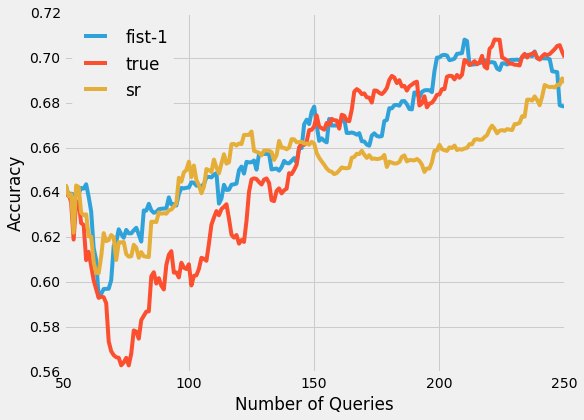

In [159]:
plot_eval(xs,[res_org['lrl1-C=1-f1'],res_org['lrl1-C=1-true'], res_org['lrl1-C=1-sr']] , labels=['fist-1','true','sr'], name='org_student.pdf')

['lr-cw-C=auto-f1', 'lr-cw-C=auto-sr', 'lr-cw-C=auto-true']


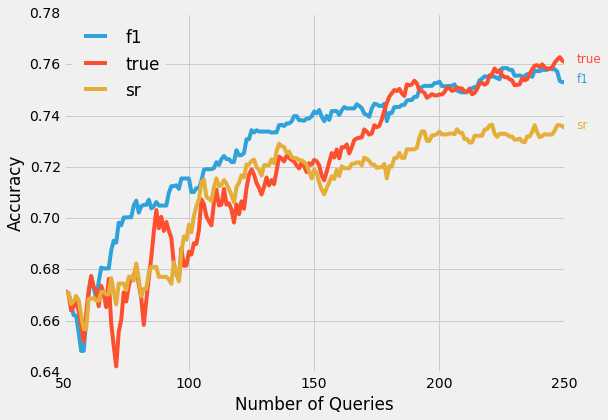

In [158]:
# plot_eval(xs,[res_org['lr-cw-C=1-f1'],res_org['lrl1-C=1-true'], res_org['lrl1-C=1-sr']] , labels=['fist-1','true','sr'], name='org_student.pdf')
au_lbl = [k for k in res_org.keys() if 'auto' in k]
print au_lbl
plot_eval(xs,[res_org['lr-cw-C=auto-f1'],res_org['lr-cw-C=auto-true'],res_org['lr-cw-C=auto-sr'] ] , labels=['f1', 'true', 'sr'], name='auto.pdf', annotate=True)

## Try Other CW Weights

We tray a range of values between .35 and .65 for class 0 (neg).

In [133]:
# Testing other class weights

parameter = [{0:r, 1:1-r} for r in np.arange(.15, .66, .1)]
clf_name = ['lr-cw'] * len(parameter)
targets = ['f1', 'sr', 'true']
labels = {'f1':np.array(f1_target), 'true':np.array(sr_true), 'sr':np.array(sr_target)}

cw_range, cw_xs = noisy_reluctant(clf_name, parameter, targets, labels, bt_true[:50], train_bow, imdb.test)



CLF:lr-cw - PAR: {0: 0.14999999999999999, 1: 0.84999999999999998} - LAB: f1
Intercept: [ 0.08468429]
Non-zero features: 12420
Positive weights: 5596
Negative weights: 6824
Sum: -0.120119404433
L1-norm: 129.512236525
L2-norm: 1.43474063451

CLF:lr-cw - PAR: {0: 0.14999999999999999, 1: 0.84999999999999998} - LAB: sr
Intercept: [ 0.08468429]
Non-zero features: 12420
Positive weights: 5596
Negative weights: 6824
Sum: -0.120119404433
L1-norm: 129.512236525
L2-norm: 1.43474063451

CLF:lr-cw - PAR: {0: 0.14999999999999999, 1: 0.84999999999999998} - LAB: true
Intercept: [ 0.08468429]
Non-zero features: 12420
Positive weights: 5596
Negative weights: 6824
Sum: -0.120119404433
L1-norm: 129.512236525
L2-norm: 1.43474063451

CLF:lr-cw - PAR: {0: 0.25, 1: 0.75} - LAB: f1
Intercept: [ 0.07378552]
Non-zero features: 12420
Positive weights: 5590
Negative weights: 6830
Sum: -2.24470657099
L1-norm: 134.910703914
L2-norm: 1.48985253527

CLF:lr-cw - PAR: {0: 0.25, 1: 0.75} - LAB: sr
Intercept: [ 0.0737855

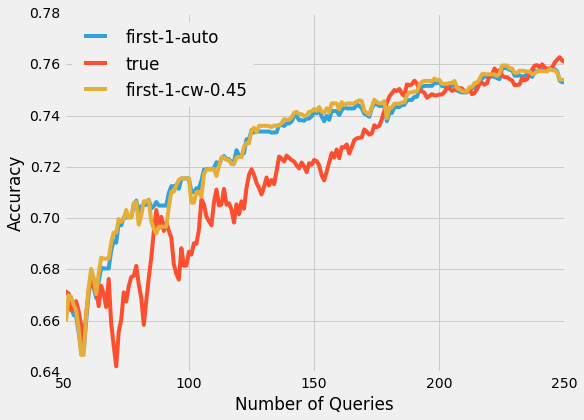

In [162]:
plot_eval(xs,[res_org['lr-cw-C=auto-f1'],res_org['lr-cw-C=auto-true'],cw_range['lr-cw-C={0: 0.45000000000000007, 1: 0.54999999999999993}-f1']] , labels=['first-1-auto', 'true', 'first-1-cw-0.45'], name='auto-fixed.pdf')

['lr-cw-C={0: 0.34999999999999998, 1: 0.65000000000000002}-f1', 'lr-cw-C={0: 0.65000000000000002, 1: 0.34999999999999998}-f1', 'lr-cw-C={0: 0.45000000000000007, 1: 0.54999999999999993}-f1', 'lr-cw-C={0: 0.55000000000000004, 1: 0.44999999999999996}-f1', 'lr-cw-C={0: 0.25, 1: 0.75}-f1', 'lr-cw-C={0: 0.14999999999999999, 1: 0.84999999999999998}-f1']


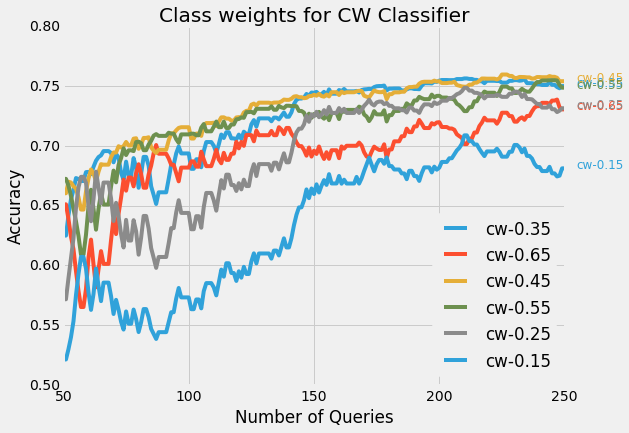

In [135]:
## Ploting F1 graphs
to_plot = [k for k in cw_range.keys() if 'f1' in k]
print to_plot
plot_eval(xs,[cw_range[k] for k in to_plot] , labels=['cw-0.35', 'cw-0.65', 'cw-0.45', 'cw-0.55', 'cw-0.25', 'cw-0.15'], name='cw_range_f1.pdf', annotate=True)
plt.title('Class weights for CW Classifier')

['lr-cw-C={0: 0.45000000000000007, 1: 0.54999999999999993}-true', 'lr-cw-C={0: 0.14999999999999999, 1: 0.84999999999999998}-true', 'lr-cw-C={0: 0.55000000000000004, 1: 0.44999999999999996}-true', 'lr-cw-C={0: 0.34999999999999998, 1: 0.65000000000000002}-true', 'lr-cw-C={0: 0.25, 1: 0.75}-true', 'lr-cw-C={0: 0.65000000000000002, 1: 0.34999999999999998}-true']


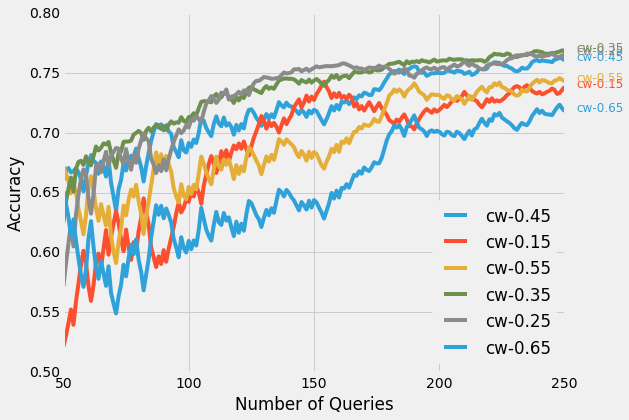

In [137]:
to_plot = [k for k in cw_range.keys() if 'true' in k]
print to_plot
plot_eval(xs,[cw_range[k] for k in to_plot] , labels=['cw-0.45','cw-0.15', 'cw-0.55', 'cw-0.35', 'cw-0.25','cw-0.65'], name='cw_range_true.pdf', annotate=True)


['lr-cw-C={0: 0.45000000000000007, 1: 0.54999999999999993}-true', 'lr-cw-C={0: 0.14999999999999999, 1: 0.84999999999999998}-true', 'lr-cw-C={0: 0.55000000000000004, 1: 0.44999999999999996}-true', 'lr-cw-C={0: 0.34999999999999998, 1: 0.65000000000000002}-true', 'lr-cw-C={0: 0.25, 1: 0.75}-true', 'lr-cw-C={0: 0.65000000000000002, 1: 0.34999999999999998}-true']


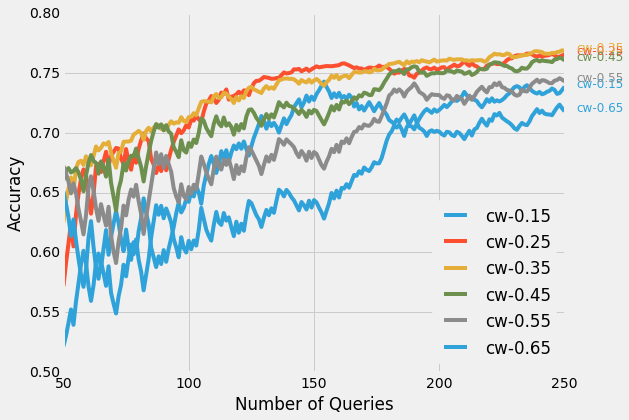

In [168]:
to_plot = [k for k in cw_range.keys() if 'true' in k]
print to_plot
g_labels= ["cw-%.2f" % r for r in np.arange(.15, .66, .1)]
# plot_eval(xs,[cw_range[k] for k in to_plot] , labels=['cw-0.45','cw-0.55', 'cw-0.15', 'cw-0.25','cw-0.35','cw-0.65'], name='cw_range_sr.pdf', annotate=True)

plot_eval(xs,[cw_range[k] for k in sorted(to_plot)] , labels=g_labels, name='cw_range_true.pdf', annotate=True)


## Try Different Bootstrap Documents

Same labels and order but with different bootstrap values 

In [93]:
from scipy.sparse import vstack

def add_instance(mat, to_add):
    test_sent = mat
    if to_add.shape[0] == 0:
        return mat
    
    for instance in to_add:
        if isinstance(test_sent, list):
            test_sent = instance
        else:
            test_sent = vstack([test_sent, instance], format='csr')
    return test_sent

def test_bootstrap(clf_name, parameter, targets, labels, data, train_bow, test_set, runs=10, bt_size=50):
    results = []
    xs = []
    for run in range(runs):
        rnd = np.random.RandomState(run * 10)
        order = rnd.permutation(len(data.target))
        bootstrap = data.target[order][:bt_size].tolist()
        bt_bow = data.bow[order][:bt_size]
        x_bow = add_instance(bt_bow, train_bow[50:])
        
        res, x = noisy_reluctant(clf_name, parameter, targets, labels, bootstrap, x_bow, test_set)
        results.append(res)
        xs.append(x)
    return results, xs

clf_name = ['lrl1']
parameter = [1]
targets = ['f1','sr', 'true']
labels = {'f1':np.array(f1_target), 'true':np.array(sr_true), 'sr':np.array(sr_target)}
btsps, btxs = test_bootstrap(clf_name, parameter, targets, labels, imdb.train, train_bow, imdb.test, runs=10, bt_size=50)


CLF:lrl1 - PAR: 1 - LAB: f1
Intercept: [-0.38156791]
Non-zero features: 25
Positive weights: 14
Negative weights: 11
Sum: 2.5516040719
L1-norm: 11.915614489
L2-norm: 3.06289778042

CLF:lrl1 - PAR: 1 - LAB: sr
Intercept: [-0.41041358]
Non-zero features: 25
Positive weights: 14
Negative weights: 11
Sum: 2.58023462369
L1-norm: 11.8856607961
L2-norm: 3.06196347262

CLF:lrl1 - PAR: 1 - LAB: true
Intercept: [-0.41007414]
Non-zero features: 25
Positive weights: 14
Negative weights: 11
Sum: 2.58041826553
L1-norm: 11.886194259
L2-norm: 3.06194983755

CLF:lrl1 - PAR: 1 - LAB: f1
Intercept: [ 0.]
Non-zero features: 26
Positive weights: 16
Negative weights: 10
Sum: 3.45369230863
L1-norm: 12.3853986137
L2-norm: 3.25877553104

CLF:lrl1 - PAR: 1 - LAB: sr
Intercept: [ 0.]
Non-zero features: 26
Positive weights: 16
Negative weights: 10
Sum: 3.44053994331
L1-norm: 12.3867591101
L2-norm: 3.25582461303

CLF:lrl1 - PAR: 1 - LAB: true
Intercept: [ 0.]
Non-zero features: 26
Positive weights: 16
Negative we

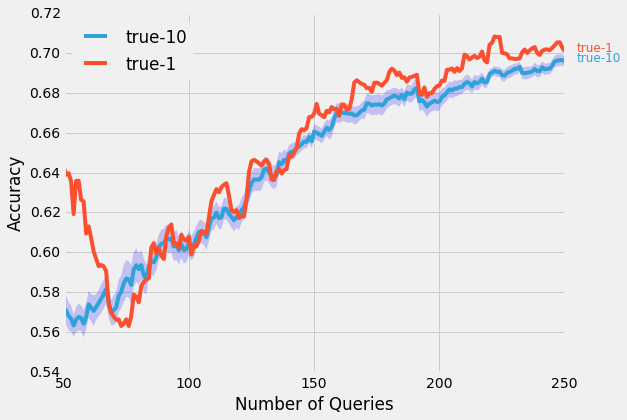

In [121]:
avg = []
for i in range(len(btsps)):
    avg.append(btsps[i]['lrl1-C=1-true'])

ym = np.mean(avg, axis=0)

plot_eval([btxs[0][0],xs[0]],[ym,res_org['lrl1-C=1-true']] , labels=['true-10','true-1'], name='bts.pdf', annotate=True)

stdc = np.std(avg, axis=0) / np.sqrt(10.)
plt.fill_between(x, ym-stdc, ym+stdc, 
    alpha=0.2 , facecolor='b',interpolate=True,  
    linewidth=0, linestyle='-', label='mean')
plt.savefig('bts.pdf',bbox_inches="tight", dpi=200, transparent=True)

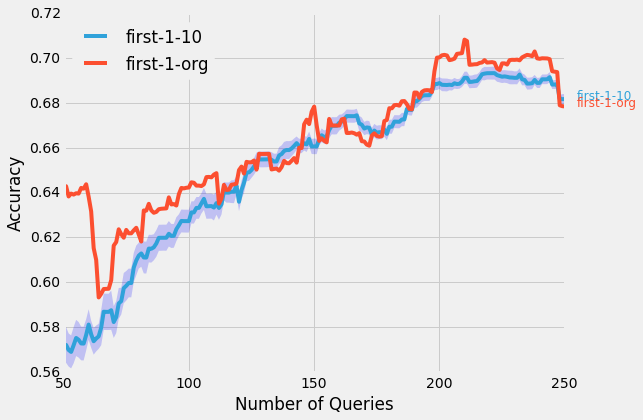

In [163]:
avg = []
for i in range(len(btsps)):
    avg.append(btsps[i]['lrl1-C=1-f1'])

ym = np.mean(avg, axis=0)

plot_eval([btxs[0][0],xs[0]],[ym,res_org['lrl1-C=1-f1']] , labels=['first-1-10','first-1-org'], name='bts_f1.pdf', annotate=True)

stdc = np.std(avg, axis=0) / np.sqrt(10.)
plt.fill_between(x, ym-stdc, ym+stdc, 
    alpha=0.2 , facecolor='b',interpolate=True,  
    linewidth=0, linestyle='-', label='mean')
plt.savefig('bts_f1.pdf',bbox_inches="tight", dpi=200, transparent=True)

In [191]:
clf_name = ['lrl1', 'lr-cw', 'lrl1']
parameter = [1, 'auto', 100]
targets = ['f1','true']
labels = {'f1':np.array(f1_target), 'true':np.array(sr_true), 'sr':np.array(sr_target)}
trial10, xtrial10 = test_bootstrap(clf_name, parameter, targets, labels, imdb.train, train_bow, imdb.test, runs=10, bt_size=50)


CLF:lrl1 - PAR: 1 - LAB: f1
Intercept: [-0.41128762]
Non-zero features: 25
Positive weights: 14
Negative weights: 11
Sum: 2.58140224605
L1-norm: 11.8855723419
L2-norm: 3.06218112753

CLF:lrl1 - PAR: 1 - LAB: true
Intercept: [-0.3813408]
Non-zero features: 25
Positive weights: 14
Negative weights: 11
Sum: 2.55345533995
L1-norm: 11.9162173448
L2-norm: 3.06365898502

CLF:lr-cw - PAR: auto - LAB: f1
Intercept: [-0.09941809]
Non-zero features: 10973
Positive weights: 5195
Negative weights: 5778
Sum: 4.46912584792
L1-norm: 149.953495698
L2-norm: 1.76417013352

CLF:lr-cw - PAR: auto - LAB: true
Intercept: [-0.09941809]
Non-zero features: 10973
Positive weights: 5195
Negative weights: 5778
Sum: 4.46912584792
L1-norm: 149.953495698
L2-norm: 1.76417013352

CLF:lrl1 - PAR: 100 - LAB: f1
Intercept: [-0.41798683]
Non-zero features: 67
Positive weights: 31
Negative weights: 36
Sum: 6.46751067262
L1-norm: 57.984442984
L2-norm: 9.74902644934

CLF:lrl1 - PAR: 100 - LAB: true
Intercept: [-0.39399912]
N

[ 0.57201969  0.57070711]


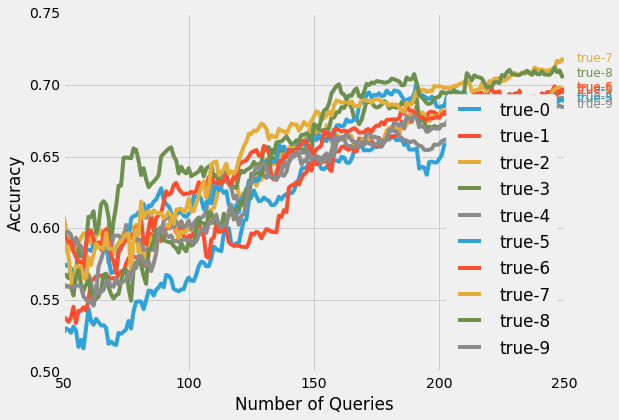

In [165]:
avg = []
for i in range(len(btsps)):
    avg.append(btsps[i]['lrl1-C=1-true'])

    
plot_eval([xs[0]] * 10,avg , labels=['true-{}'.format(i) for i in range(10)], name='bts_all.pdf', annotate=True)

print np.mean(avg, axis=0)[:2]


## Perfect Reluctant Oracles

In [43]:
## Perfect-reluctant

def perfect_reluctant(clf_name, parameter, targets, labels, bootstrap, train_bow, test_set):
    from itertools import product
    test = product(zip(clf_name, parameter), targets)
    results = {}
    legend = {}
    xs = []
    for a,b in test:
        experiment = "CLF:%s - PAR: %s - LAB: %s" % (a[0], a[1], b)
        legend = "%s-C=%s-%s" % (a[0], a[1], b)
        print experiment
        train_target= [w for w in bootstrap]
        
        ext = np.array([tru for tru in labels['true']])  ## get true labels
        ext[labels[b] == 2] = 2  ## Except when neutral 
        train_target.extend(ext)
        
        x, y = evaluate_student(a[0], train_bow, train_target, test_set, parameter=a[1])
        results[legend] = y
        xs.append(x)
    return results, xs

clf_name = ['lrl1', 'lrl1', 'lr-cw']
parameter = [1,100,{0:.45, 1:.55}]
targets = ['f1', 'sr']
labels = {'f1':np.array(f1_target), 'true':np.array(sr_true), 'sr':np.array(sr_target)}

per_rel, xs = perfect_reluctant(clf_name, parameter, targets, labels, bt_true[:50], train_bow, imdb.test)


CLF:lrl1 - PAR: 1 - LAB: f1
Intercept: [ 0.]
Non-zero features: 33
Positive weights: 18
Negative weights: 15
Sum: -1.73082082141
L1-norm: 11.5838010166
L2-norm: 2.73241177629
CLF:lrl1 - PAR: 1 - LAB: sr
Intercept: [ 0.]
Non-zero features: 33
Positive weights: 18
Negative weights: 15
Sum: -1.7115599133
L1-norm: 11.5843535892
L2-norm: 2.7160270111
CLF:lrl1 - PAR: 100 - LAB: f1
Intercept: [ 0.05953043]
Non-zero features: 109
Positive weights: 61
Negative weights: 48
Sum: -3.14906374983
L1-norm: 62.9952750975
L2-norm: 8.55500121986
CLF:lrl1 - PAR: 100 - LAB: sr
Intercept: [ 0.11416581]
Non-zero features: 110
Positive weights: 51
Negative weights: 59
Sum: -2.57487347484
L1-norm: 63.4570970673
L2-norm: 8.35763351961
CLF:lr-cw - PAR: {0: 0.45, 1: 0.55} - LAB: f1
Intercept: [ 0.05662202]
Non-zero features: 12420
Positive weights: 5570
Negative weights: 6850
Sum: -5.05699470448
L1-norm: 138.431960405
L2-norm: 1.52424108891
CLF:lr-cw - PAR: {0: 0.45, 1: 0.55} - LAB: sr
Intercept: [ 0.05662202]
N

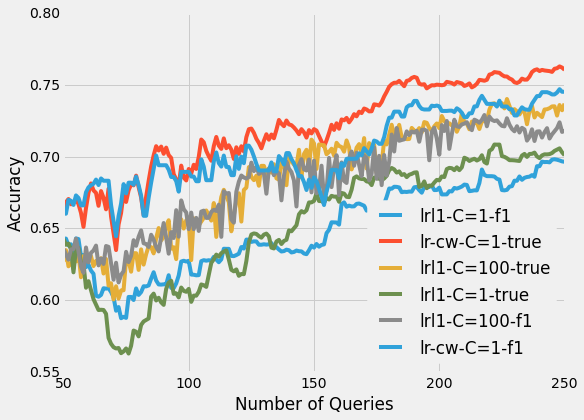

In [47]:
plot_eval(xs, results.values(), labels=results.keys(), name='true_effect.pdf')

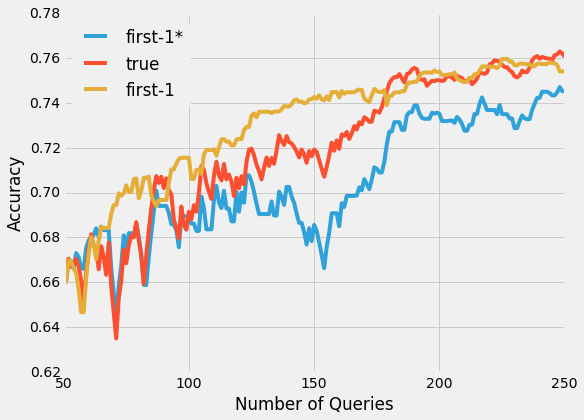

In [110]:
plot_eval(xs,[results['lr-cw-C=1-f1'],results['lr-cw-C=1-true'], res_org['lr-cw-C=1-f1']], labels=['first-1*','true', 'first-1'], name='cw_true_effect.pdf')

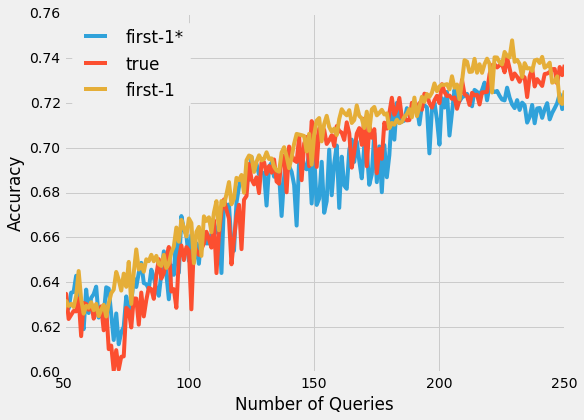

In [111]:
plot_eval(xs, [results['lrl1-C=100-f1'],results['lrl1-C=100-true'], res_org['lrl1-C=100-f1']], labels= ['first-1*','true','first-1'], name='c100_true_effect.pdf')

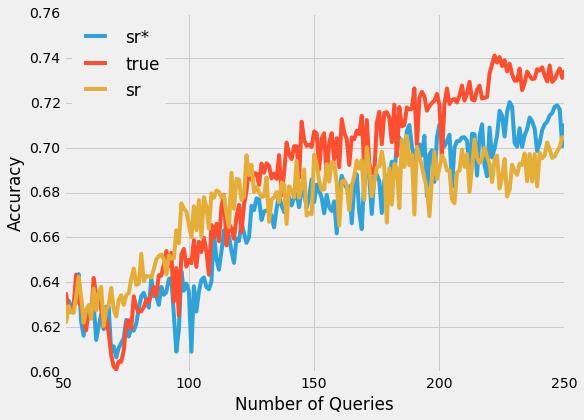

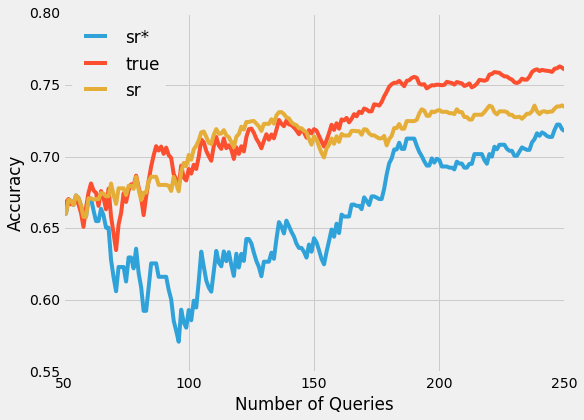

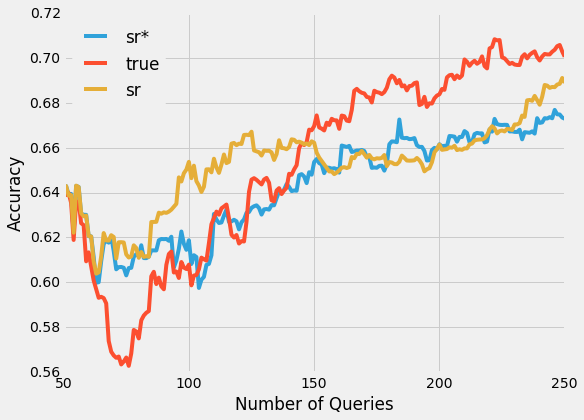

In [115]:
plot_eval(xs, [results['lrl1-C=100-sr'],results['lrl1-C=100-true'], res_org['lrl1-C=100-sr']], labels= ['sr*','true','sr'], name='c100_true_sr_effect.pdf')
plot_eval(xs,[results['lr-cw-C=1-sr'],results['lr-cw-C=1-true'], res_org['lr-cw-C=1-sr']], labels=['sr*','true', 'sr'], name='cw_true_sr_effect.pdf')
plot_eval(xs,[results['lrl1-C=1-sr'],results['lrl1-C=1-true'], res_org['lrl1-C=1-sr']] , labels=['sr*','true','sr'], name='c1_true_sr_effect.pdf')


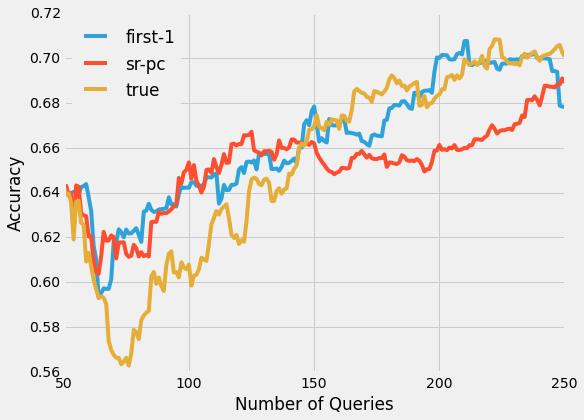

In [61]:
plot_eval([x,x,x], [y_f1, y_sr, y_true], labels=['first-1','sr-pc', 'true'], name='user_study.pdf')

# Evaluating How Important is the Size Order 

We try the learner with the study labels and order based on size and compare learning curves

In [120]:
doc_text, snip_text = read_text(DATA + "/imdb-rnd-sr-expert1-labels.txt")

##Get the lenght of the documents
doc_len = [len(d.split()) for d in doc_text]

# ext = np.array([tru for tru in labels['true']])  ## get true labels
# train_target.extend(ext)

## Figure the order of the labesl
order2 = np.argsort(doc_len)
order = np.append(range(50), order2)


clf_name = ['lrl1', 'lrl1', 'lr-cw']
parameter = [1,100,1]
targets = ['f1', 'true','sr']
targets = ['sr']
labels = {'f1':np.array(f1_target), 'true':np.array(sr_true), 'sr':np.array(sr_target)}

test = product(zip(clf_name, parameter), targets)
# res_ord = {}
xs = []
for a,b in test:
    experiment = "CLF:%s - PAR: %s - LAB: %s" % (a[0], a[1], b)
    legend = "%s-C=%s-%s" % (a[0], a[1], b)
    print experiment

    ## Build the labels of the method
    train_target= bt_true[:50]
    train_target.extend(labels[b])
    
    x, y = evaluate_student(a[0],train_bow[order], np.array(train_target)[order],imdb.test, parameter=a[1])
    res_ord[legend] = y
    xs.append(x)



Number of fields: 7
Number of records: 200
CLF:lrl1 - PAR: 1 - LAB: sr
CLF:lrl1 - PAR: 100 - LAB: sr
CLF:lr-cw - PAR: 1 - LAB: sr


Class distribution: 0.462686567164
Class distribution: 0.462686567164
Class distribution: 0.462686567164


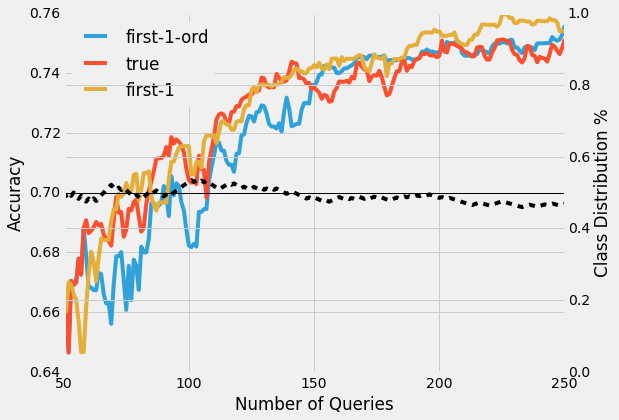

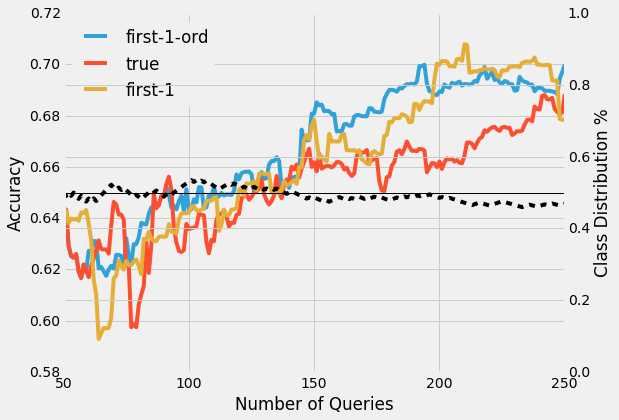

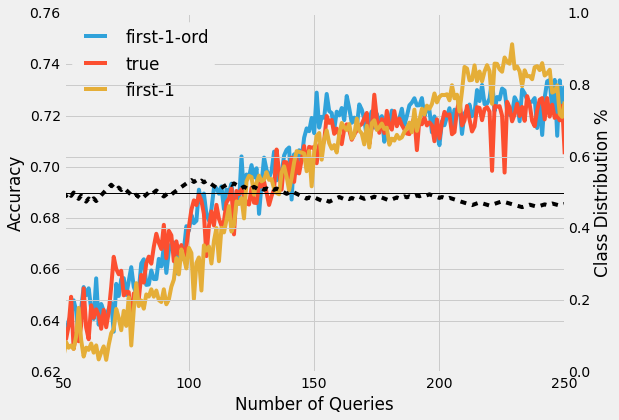

In [117]:
# [res_ord['lrl1-C=1-f1'],res_ord['lrl1-C=1-true']] , labels=['lrl1-C=1-f1','lrl1-C=1-true']
# [res_ord['lrl1-C=100-f1'],res_ord['lrl1-C=100-true']], labels= ['lrl1-C=100-f1','lrl1-C=100-true']
# [res_ord['lr-cw-C=1-f1'],res_ord['lr-cw-C=1-true']], labels=['lr-cw-C=1-f1','lr-cw-C=1-true']
def plot_eval_order(xs, ys, labls, name='file.png'):
    plot_eval(xs, ys, labels=labls, name=name)

    # Get class distribution (true) along the curve 
    distribution = bt_true[:50]
    distribution.extend(sr_true)
    distribution = np.array(distribution)[order]
#     print "Class distribution:", np.mean(distribution[49:])
#     ## Class 1 will be the minority - it sums the 1's in the array
#     class_dist = distribution.cumsum()[49:] / range(50,len(distribution)+1)
    class_dist = compute_distribution(distribution)
    ax = plt.axes()
    ax2 = ax.twinx()
    ax2.plot(x, class_dist, 'k--',label='true-dist')
    ax2.plot(x, [0.5] * len(x), 'k-',label='true-dist', linewidth=1)

    ax2.set_ylabel('Class Distribution %')
    plt.ylim([0,1]) ## affects 2nd axis

    plt.savefig(name,bbox_inches="tight", dpi=200, transparent=True)

plot_eval_order(xs, [res_ord['lr-cw-C=1-f1'],res_ord['lr-cw-C=1-true'], res_org['lr-cw-C=1-f1']], ['first-1-ord','true', 'first-1'], name='cw_size_effect.pdf')
plot_eval_order(xs, [res_ord['lrl1-C=1-f1'],res_ord['lrl1-C=1-true'], res_org['lrl1-C=1-f1']], ['first-1-ord','true', 'first-1'], name='l1_size_effect.pdf')
plot_eval_order(xs, [res_ord['lrl1-C=100-f1'],res_ord['lrl1-C=100-true'], res_org['lrl1-C=100-f1']], ['first-1-ord','true', 'first-1'], name='l100_size_effect.pdf')

Class distribution: 0.462686567164
Class distribution: 0.462686567164
Class distribution: 0.462686567164


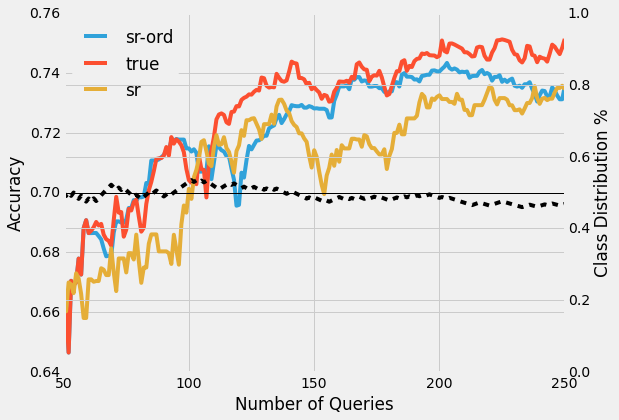

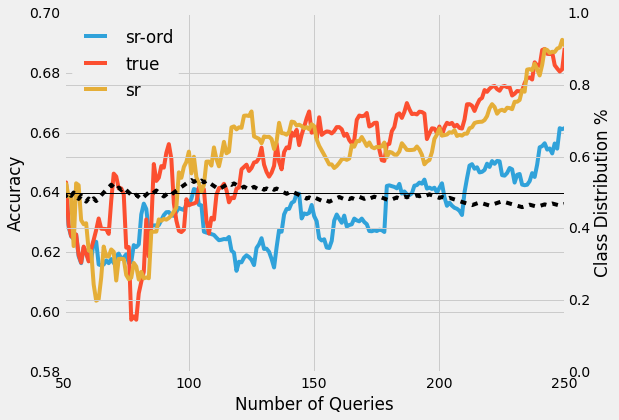

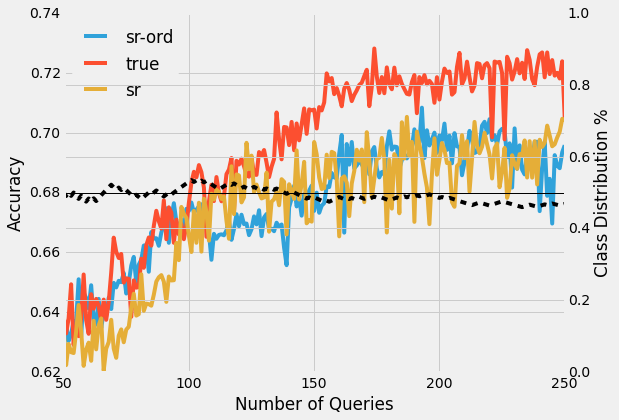

In [121]:
plot_eval_order(xs, [res_ord['lr-cw-C=1-sr'],res_ord['lr-cw-C=1-true'], res_org['lr-cw-C=1-sr']], ['sr-ord','true', 'sr'], name='cw_size_sr_effect.pdf')
plot_eval_order(xs, [res_ord['lrl1-C=1-sr'],res_ord['lrl1-C=1-true'], res_org['lrl1-C=1-sr']], ['sr-ord','true', 'sr'], name='l1_size_sr_effect.pdf')
plot_eval_order(xs, [res_ord['lrl1-C=100-sr'],res_ord['lrl1-C=100-true'], res_org['lrl1-C=100-sr']], ['sr-ord','true', 'sr'], name='l100_size_sr_effect.pdf')

Class distribution: 0.462686567164


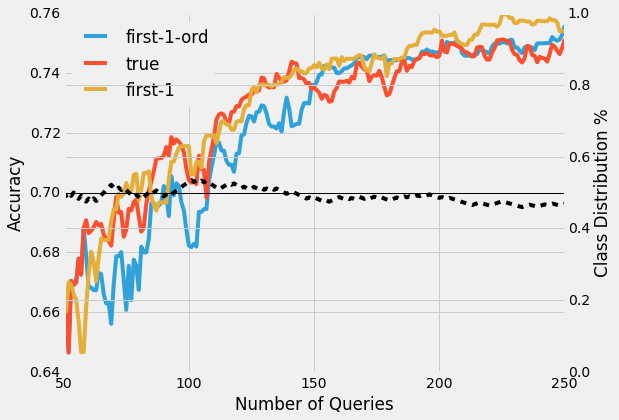

In [113]:
# [res_ord['lrl1-C=1-f1'],res_ord['lrl1-C=1-true']] , labels=['lrl1-C=1-f1','lrl1-C=1-true']
# [res_ord['lrl1-C=100-f1'],res_ord['lrl1-C=100-true']], labels= ['lrl1-C=100-f1','lrl1-C=100-true']
# [res_ord['lr-cw-C=1-f1'],res_ord['lr-cw-C=1-true']], labels=['lr-cw-C=1-f1','lr-cw-C=1-true']
plot_eval(xs, [res_ord['lr-cw-C=1-f1'],res_ord['lr-cw-C=1-true'], res_org['lr-cw-C=1-f1']], labels=['first-1-ord','true', 'first-1'], name='cw_size_effect.pdf')
# plot_eval(xs, res_ord.values(), labels=res_ord.keys(), name='size_effect.pdf')
# Get class distribution (true) along the curve 
distribution = bt_true[:50]
distribution.extend(sr_true)
distribution = np.array(distribution)[order]
print "Class distribution:", np.mean(distribution[49:])
## Class 1 will be the minority - it sums the 1's in the array
class_dist = distribution.cumsum()[49:] / range(50,len(distribution)+1)

ax = plt.axes()
ax2 = ax.twinx()
ax2.plot(x, class_dist, 'k--',label='true-dist')
ax2.plot(x, [0.5] * len(x), 'k-',label='true-dist', linewidth=1)

# ax2.plot([50,250], [.5,.5], '--',label='50%')
ax2.set_ylabel('Class Distribution %')
plt.ylim([0,1]) ## affects 2nd axis

plt.savefig('cw_size_effect.pdf',bbox_inches="tight", dpi=200, transparent=True)



In [88]:
from scipy import stats
print res_ord.keys()
print stats.ttest_ind(*[v for k,v in res_ord.items() if 'lrl1-C=1-' in k ])
print stats.ttest_ind(res_ord['lrl1-C=1-f1'],res_ord['lrl1-C=1-true'])
print stats.ttest_ind(res_ord['lrl1-C=100-f1'],res_ord['lrl1-C=100-true'])
print stats.ttest_ind(res_ord['lr-cw-C=1-f1'],res_ord['lr-cw-C=1-true'])


['lrl1-C=1-f1', 'lr-cw-C=1-true', 'lrl1-C=100-true', 'lrl1-C=1-true', 'lrl1-C=100-f1', 'lr-cw-C=1-f1']
(6.0034035084809068, 4.3381623096477253e-09)
(6.0034035084809068, 4.3381623096477253e-09)
(1.194003780333208, 0.23318408609481023)
(-1.9089075961282982, 0.056989365053419047)


## Evaluate Classifiers with True Labels

Use the same documents as in the user study and use the true labels to see if they make a difference. Also, test with the human labels and observe the differences. 

In [17]:
#Evaluate MNB
print "EValuating MNB"
train_target= bt_true[:50]
train_target.extend(sr_true)
x, y_mnb = evaluate_student('mnb',train_bow, train_target,imdb.test, parameter=.5)

#Evaluate lrl1-C=100
print "Evaluating LR"
train_target= bt_true[:50]
train_target.extend(sr_true)
x, y_l110 = evaluate_student('lrl1',train_bow, train_target,imdb.test,parameter=100)

#Evaluate SVC 
# train_target= bt_true[:50]
# train_target.extend(sr_true)
# x, y_svc = evaluate_student('svc',train_bow, train_target,imdb.test,parameter=10)

#Evaluate class weighted LR
print "Evaluating CW"
train_target= bt_true[:50]
train_target.extend(sr_true)
x, y_cw = evaluate_student('lr-cw',train_bow, train_target,imdb.test, parameter=1)



EValuating MNB
Evaluating LR
Evaluating CW


## Test Human Labels 

Using mnb, lr with various options

# Evaluate Order of Experiments

We tried 100 random orderings of the user study labels and measure the proportion of runs that are first-1 and SR wins. 



In [59]:
print [sr_expert[sr_index.index(i)] for i in f1_index][:10]


[1.0, 0.0, 1.0, 2.0, 1.0, 0.0, 2.0, 0.0, 2.0, 2.0]


In [ ]:
def try_ordering(clf_name, train_bow, bt_target, true_target, f1_target, test, parameter=1, runs=100):
    
    results = []
    curves = []
    for i in range(runs):  
        order = np.random.RandomState(i * 10)
        
        order2 = order.choice(200, 200, replace=False) + 50  ## adjust for bootstrap
        order = np.append(range(50), order2)
        #Evaluate class weighted f1
        train_target= bt_target[:50]
        train_target.extend(f1_target)
        x, f1 = evaluate_student(clf_name,train_bow[order], np.array(train_target)[order],test, parameter=parameter)

        #Evaluate class weighted true
        train_target= bt_target[:50]
        train_target.extend(true_target)
        x, tr = evaluate_student(clf_name,train_bow[order], np.array(train_target)[order],test, parameter=parameter)
        
        print "run", i, len(f1), len(tr), stats.ttest_ind(f1, tr)
        results.append(stats.ttest_ind(f1, tr))
        curves.append([f1,tr])
    print "first-1 wins", len([a[1] for a in results if a[1] < 0.05 and a[0] > 0]) ## f1 wins  
    print "True wins",  len([a[1] for a in results if a[1] < 0.05 and a[0] < 0])
    return results, curves
    
# runs, curves = try_ordering('lr-cw', train_bow, bt_true[:50], sr_true, f1_target, imdb.test, parameter=1, runs=100)
runs2, curves2 = try_ordering('lrl1', train_bow, bt_true[:50], sr_true, f1_target, imdb.test, parameter=1, runs=100)


In [126]:
print "first-1 wins", len([a[1] for a in runs if a[1] >= 0.05 ])
print 55+15+30

first-1 wins 30
100


In [115]:
train_target= bt_true[:50]
train_target.extend(sr_true)
rnd_test = np.random.RandomState(1)
orderx = rnd_test.choice(200,200,replace=False) + 50

order=np.append(range(50), orderx)

train_target= bt_true[:50]
train_target.extend(f1_target)
# x, f1 = evaluate_student('lr-cw',train_bow[order], np.array(train_target)[order],imdb.test, parameter=1)

train_target= bt_true[:50]
train_target.extend(sr_true)
# x, tr = evaluate_student('lr-cw',train_bow[order], np.array(train_target)[order],imdb.test, parameter=1)

print stats.ttest_ind(f1, tr)
        

(3.6958965478032786, 0.00024963824769042795)


In [68]:

print "True vs. rest"
# print "t-statistic: %f, p-value: %f" % stats.ttest_ind(y_true, y_f1)
print "MNB: t-stat: %f, p-value: %f" % stats.ttest_rel(y_true, y_mnb)
print "LR-L1-C=10: t-stat: %f, p-value: %f" % stats.ttest_rel(y_true, y_l110)
# print "SVC: t-stat: %f, p-value: %f" % stats.ttest_rel(y_true, y_svc)

print "SVC: t-stat: %f, p-value: %f" % stats.ttest_rel(y_cw, f1_cw)
print "SVC: t-stat: %f, p-value: %f" % stats.ttest_rel(f1_cw, sr_cw)



True vs. rest
MNB: t-stat: 12.440929, p-value: 0.000000
LR-L1-C=10: t-stat: -34.576518, p-value: 0.000000
SVC: t-stat: -10.778611, p-value: 0.000000
SVC: t-stat: 25.124440, p-value: 0.000000


## Simulated Oracle Evaluation

Using a simulated oracle (with the same parameters as the paper) simulate the evaluation of the 

In [149]:
# Get SR snippets
doc_text, snip_text = read_text(DATA + "/imdb-rnd-sr-expert1-labels.txt")
snip_bow = vct.transform(snip_text)


#Evaluate simulated
simsr_target= bt_true[:50]

train_y = sim_oracle.predict(snip_bow)
probs = sim_oracle.predict_proba(snip_bow)
unc = 1. - probs.max(1)
neutral = unc > .4
train_y[neutral] = 2
simsr_target.extend(train_y)

# x, sim_sr = evaluate_student(clf,train_bow, simsr_target, imdb.test)
x, sim_sr = evaluate_student(clf,train_bow, simsr_target, imdb.test)





Number of fields: 7
Number of records: 200


In [150]:
# Get F1 snippets
doc_text, snip_text = read_text(DATA + "/imdb-rnd-first1-expert2-labels.txt")
snip_bow = vct.transform(snip_text)


#Evaluate simulated
simf1_target= bt_true[:50]
train_y = sim_oracle.predict(snip_bow)
probs = sim_oracle.predict_proba(snip_bow)
unc = 1. - probs.max(1)
neutral = unc > .4
train_y[neutral] = 2  #targets by oracle

#reorder targets based on sequence
new_target = [train_y[f1_index.index(i)] for i in sr_index]
simf1_target.extend(new_target)

x, sim_f1 = evaluate_student(clf,train_bow, simf1_target, imdb.test)




Number of fields: 7
Number of records: 200


In [502]:
def plot_evaluation(x_axis, y_axis, labels, class_dist, name='simulated.png'):
    ## Plot student evaluation with simulated and study
    fig = plt.figure(figsize=(8,6))
    colors_n = brewer2mpl.get_map('Set1', 'qualitative', 8).mpl_colors[:len(x_axis)]

    i = 0
    for x, y, l in zip(x_axis, y_axis, labels):
        plt.plot(x,y,label=l, color=colors_n[i])
        i +=1
   
    plt.ylabel("Accuracy")
    plt.ylim([.55,.75])
    plt.legend(loc='best')
    plt.title("Student Accuracy")

    ## Create a secondary y-axis
    ax = plt.axes()
    ax2 = ax.twinx()
    ax2.plot(x, class_dist, 'k--',label='true-dist')
    # ax2.plot([50,250], [.5,.5], '--',label='50%')
    ax2.set_ylabel('Class Distribution %')
    plt.ylim([0,1]) ## affects 2nd axis

    plt.xlabel("Number of Queries")

    plt.savefig(name,bbox_inches="tight", dpi=200, transparent=True)



Average distribution 0.455, min=0.429, max=0.500


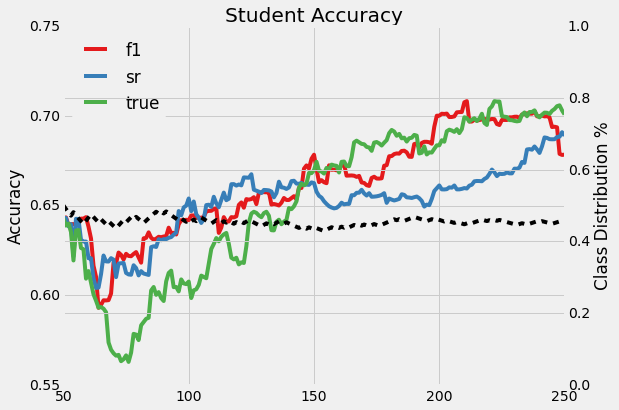

In [516]:
plot_evaluation([x,x,x], [y_f1, y_sr, y_true], ['f1','sr', 'true', 'sim-sr'], class_dist, name='sim_student.pdf')
print "Average distribution %.3f, min=%.3f, max=%.3f" % (class_dist.mean(), class_dist.min(), class_dist.max())



# Test Bootstrap Classifier

We measure statistics on the feature weights fitted by the classifier right after bootstrap. We want to test what makes the different among the various classifiers tested

In [184]:
clf = get_classifier('l1-cw', parameter='auto')
clf.fit(train_bow[:50], bt_true[:50])
print clf.intercept_
non_zero_features(clf)

[ 0.]
Non-zero features: 33
Positive weights: 18
Negative weights: 15
Sum: -1.70978592496
L1-norm: 11.5857429923
L2-norm: 2.70986123049


In [185]:
clf = get_classifier('l1-cw', parameter={0:.45, 1:.55})
clf.fit(train_bow[:50], bt_true[:50])
print clf.intercept_
non_zero_features(clf)

[ 0.]
Non-zero features: 20
Positive weights: 9
Negative weights: 11
Sum: -0.498095008462
L1-norm: 4.68983141808
L2-norm: 1.4742510973


In [176]:
clf = get_classifier('lr-cw', parameter='auto')
print clf

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)


In [172]:
clf = get_classifier('lrl1', parameter=1)
print clf

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.0001)


In [186]:
clf_name = ['l1-cw']
parameter = ['auto', {0:0.45, 1:0.55}]
targets = ['f1', 'sr', 'true']
labels = {'f1':np.array(f1_target), 'true':np.array(sr_true), 'sr':np.array(sr_target)}
cwl1, cwl1x = noisy_reluctant(clf_name, parameter, targets, labels, bt_true[:50], train_bow, imdb.test)


CLF:l1-cw - PAR: auto - LAB: f1
Intercept: [ 0.]
Non-zero features: 33
Positive weights: 18
Negative weights: 15
Sum: -1.70790528457
L1-norm: 11.5853850849
L2-norm: 2.70900688066

CLF:l1-cw - PAR: auto - LAB: sr
Intercept: [ 0.]
Non-zero features: 34
Positive weights: 19
Negative weights: 15
Sum: -1.70527835824
L1-norm: 11.5854451732
L2-norm: 2.71290435612

CLF:l1-cw - PAR: auto - LAB: true
Intercept: [ 0.]
Non-zero features: 33
Positive weights: 18
Negative weights: 15
Sum: -1.70945063926
L1-norm: 11.5842254856
L2-norm: 2.71330507862


['lr-cw-C=auto-f1', 'lr-cw-C=auto-sr', 'lr-cw-C=auto-true']


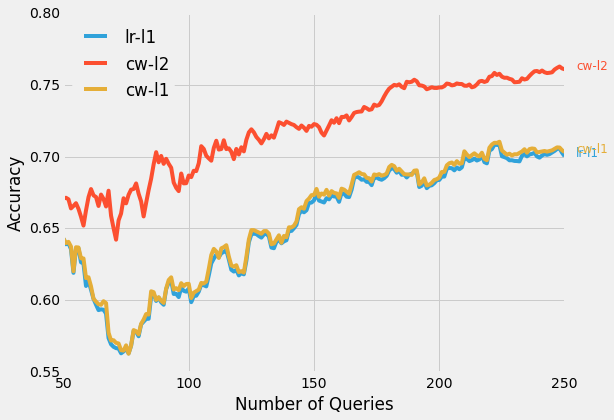

In [190]:
au_lbl = [k for k in res_org.keys() if 'auto' in k]
print au_lbl
# plot_eval(xs,[res_org['lr-cw-C=auto-f1'],res_org['lr-cw-C=auto-true'],res_org['lr-cw-C=auto-sr'] ] , labels=['f1', 'true', 'sr'], name='auto.pdf', annotate=True)
plot_eval(xs,[res_org['lrl1-C=1-true'], res_org['lr-cw-C=auto-true'],cwl1['l1-cw-C=auto-true']] , labels=['lr-l1', 'cw-l2', 'cw-l1'], name='cw-l1l2.pdf', annotate=True)

In [187]:
print cwl1.keys()

['l1-cw-C=auto-true', 'l1-cw-C=auto-sr', 'l1-cw-C=auto-f1']
